The Eluvio dataset is a collection of "News Articles titles"  <br>
<u>Problem Statement :</u> <br>Based on the day, time, sentiment,year and number of post/author can the particular news article's up_votes cross a particular threshold and fall withing one of the bins 'low' 'moderate' and 'high' <br>
Tried to create a tfidf of the title and passed that as data and tried to see if that helps in predicting news article's up_votes cross a particular threshold and fall withing one of the bins 'low' 'moderate' and 'high'

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [87]:
from nltk.corpus import stopwords
import nltk

import seaborn as sns
import re
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from nltk.sentiment import SentimentIntensityAnalyzer
import category_encoders as ce
from sklearn import tree
from sklearn.linear_model import Perceptron,LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import  accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [3]:
data = pd.read_csv('Eluvio_DS_Challenge.csv')
data.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


<h3> <u>Exploratory Data Analysis </u> </h3>

In [4]:
print(data.shape)
print(data.columns)

(509236, 8)
Index(['time_created', 'date_created', 'up_votes', 'down_votes', 'title',
       'over_18', 'author', 'category'],
      dtype='object')


- check for null/empty values

In [5]:
data.isnull().any()

time_created    False
date_created    False
up_votes        False
down_votes      False
title           False
over_18         False
author          False
category        False
dtype: bool

In [6]:
data.dtypes

time_created     int64
date_created    object
up_votes         int64
down_votes       int64
title           object
over_18           bool
author          object
category        object
dtype: object

- lets check how valuable each column is w.r.t information it provides

In [7]:
print(len(set(data['category'])))
print(len(set(data['author'])))
print(len(set(data['over_18'])))
print(len(set(data['down_votes'])))
print(len(set(data['up_votes'])))
print(len(set(data['date_created'])))
print(len(set(data['time_created'])))

1
85838
2
1
5782
3223
508329


- we can see that category is of no use as all values are the same <br>
- we can see that 85838 different authors are there we can't encode all of them/or cluster them so as of now they are of no use to us <br>
- down_votes are of no use only one value <br>
- we can see ,many articles where written on the same date <br>
- we have to get the time_created into a readable/useful format 

 ------------------------------------------------------------------------------------------------

- lets change time_created, to something more useful and see if we can extrac more useful information from date_created

In [8]:
data['time_created'] = pd.to_datetime(data['time_created'], unit='s').dt.time

In [9]:
hours = []
for time in data['time_created']:
    hours.append(time.hour)

In [10]:
data['time_created'] = hours

In [11]:
 data['date_created'] = pd.to_datetime(data['date_created'])

In [12]:
data['year'] = data['date_created'].dt.year

In [13]:
data['day'] = data['date_created'].dt.dayofweek

In [14]:
data.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,year,day
0,3,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,2008,4
1,3,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,2008,4
2,3,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,2008,4
3,3,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,2008,4
4,15,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,2008,4


In [15]:
data.dtypes

time_created             int64
date_created    datetime64[ns]
up_votes                 int64
down_votes               int64
title                   object
over_18                   bool
author                  object
category                object
year                     int64
day                      int64
dtype: object

------------------------------------------------------------------------------------------------------------------

- lets see how many posts each author has written or published <br>

In [16]:
 data['num_posts'] = data['author'].groupby(data['author']).transform('count')

- lets remove the columns we don't want category , down_votes ,date_created,author

In [17]:
data = data.drop(columns=['category', 'down_votes','date_created'])

- lets encode the over_18 <br>

In [18]:
data['over_18'] = pd.get_dummies(data['over_18'])

In [19]:
data.head()

,time_created,up_votes,title,over_18,author,year,day,num_posts
0,3,3,Scores killed in Pakistan clashes,1,polar,2008,4,50
1,3,2,Japan resumes refuelling mission,1,polar,2008,4,50
2,3,3,US presses Egypt on Gaza border,1,polar,2008,4,50
3,3,1,Jump-start economy: Give health care to all,1,fadi420,2008,4,2
4,15,4,Council of Europe bashes EU&UN terror blacklist,1,mhermans,2008,4,1


-----------------------------------------------------------------------------------------------------------------

- lets try to extrac sentiment from the title and also try topic modelling/Text summarization using the "title" column from the dataset

In [20]:
lemma=WordNetLemmatizer() 
stopwords = stopwords.words('english')

In [21]:
def clean_text(title):
    #     lets remove everything we don't want from the title using regex
    remove = [',',':','.','@','?','(',')','-','"']
#     title = re.sub('[^A-Za-z0-9]+', '', title) this is causing all the data to be merged without space
    
    tokens = word_tokenize(title.translate( {ord(elem): None for elem in remove} ))
    tokens = [w for w in tokens if w.lower() not in stopwords]
#     tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens ] 
    return tokens

In [22]:
title_vec = []
for title in data['title']:
    title_vec.append(clean_text(title))

In [23]:
data['title_vec'] = title_vec

In [24]:
data.head()

,time_created,up_votes,title,over_18,author,year,day,num_posts,title_vec
0,3,3,Scores killed in Pakistan clashes,1,polar,2008,4,50,"[Scores, killed, Pakistan, clashes]"
1,3,2,Japan resumes refuelling mission,1,polar,2008,4,50,"[Japan, resumes, refuelling, mission]"
2,3,3,US presses Egypt on Gaza border,1,polar,2008,4,50,"[US, presses, Egypt, Gaza, border]"
3,3,1,Jump-start economy: Give health care to all,1,fadi420,2008,4,2,"[Jumpstart, economy, Give, health, care]"
4,15,4,Council of Europe bashes EU&UN terror blacklist,1,mhermans,2008,4,1,"[Council, Europe, bashes, EU, &, UN, terror, b..."


- lets extract the sentiment from the title 

In [25]:
def sentiment_analysis(DATA):
  sia = SentimentIntensityAnalyzer()
  sentiment = []
  for ind in DATA.index:
    score = sia.polarity_scores(" " . join(DATA['title_vec'][ind]))
#     print(score)
    if score['compound'] > 0.0:
      sentiment.append("postive")
    elif score['compound'] < 0.0:
      sentiment.append("negative")
    else:
      sentiment.append("neutral")
  return sentiment

In [26]:
sentiment = sentiment_analysis(data)

In [27]:
data['sentiment'] =  sentiment

In [28]:
encoder= ce.OrdinalEncoder(cols=['sentiment'],return_df=True,
                           mapping=[{'col':'sentiment',
'mapping':{'neutral':0,'positive':1,'negative':2}}])

In [29]:
data['sentiment'] = encoder.fit_transform(data['sentiment'])

c:\users\sreej\appdata\local\programs\python\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [30]:
set(data['sentiment'])

{-1.0, 0.0, 2.0}

In [31]:
data.head()

,time_created,up_votes,title,over_18,author,year,day,num_posts,title_vec,sentiment
0,3,3,Scores killed in Pakistan clashes,1,polar,2008,4,50,"[Scores, killed, Pakistan, clashes]",2.0
1,3,2,Japan resumes refuelling mission,1,polar,2008,4,50,"[Japan, resumes, refuelling, mission]",0.0
2,3,3,US presses Egypt on Gaza border,1,polar,2008,4,50,"[US, presses, Egypt, Gaza, border]",0.0
3,3,1,Jump-start economy: Give health care to all,1,fadi420,2008,4,2,"[Jumpstart, economy, Give, health, care]",-1.0
4,15,4,Council of Europe bashes EU&UN terror blacklist,1,mhermans,2008,4,1,"[Council, Europe, bashes, EU, &, UN, terror, b...",2.0


In [32]:
data.dtypes

time_created      int64
up_votes          int64
title            object
over_18           uint8
author           object
year              int64
day               int64
num_posts         int64
title_vec        object
sentiment       float64
dtype: object

<br>

- TFIDF vec

In [33]:
vocab = []

def cal_tfidf():
    for t in data['title_vec']:
        vocab.extend(t)
    tfidfvectorizer = TfidfVectorizer(min_df =10**-3 ,analyzer = 'word', max_features=len(set(vocab)), stop_words='english', ngram_range=(1,3))
    tfidfvectorizer.fit(vocab)
    return tfidfvectorizer.transform(data['title'])
   
        

In [34]:
tfidf = cal_tfidf()

In [35]:
tfidf.shape

(509236, 85)

<br>

 - before we create models, lets see how the features/columns are affecting the up_votes

up_votes w.r.t year

<AxesSubplot:xlabel='year', ylabel='avg_upvotes'>

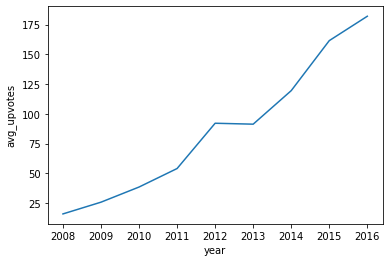

In [93]:

graph1 = data.groupby('year').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.lineplot(x='year',y='avg_upvotes',data=graph1)

<h5> we can see that as the year progressed the number of up_votes has increased meaning people are reading newspaper i guess online as we have the feature of voting  </h5>

<AxesSubplot:xlabel='day', ylabel='avg_upvotes'>

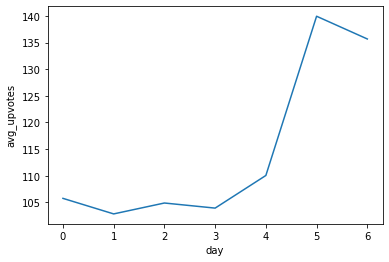

In [95]:
graph2 = data.groupby('day').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.lineplot(x='day',y='avg_upvotes',data=graph2)

<h5> so here we can see that the articles published more towards the weekend have a higher probability of getting good reach and hence more up_votes

<AxesSubplot:xlabel='over_18', ylabel='avg_upvotes'>

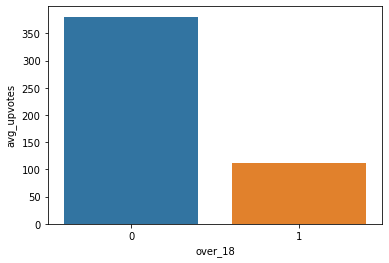

In [96]:
graph3 = data.groupby('over_18').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.barplot(x='over_18',y='avg_upvotes',data=graph3)

<h5>over_18 = False is encode as 1 <br>
over_18 = True is encode as 0 <br>
we can clearly see that people above 18 generally read newspapers and have been voting on the articles <br> </h5>

<AxesSubplot:xlabel='time_created', ylabel='avg_upvotes'>

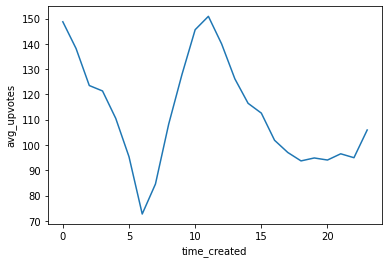

In [100]:
graph4 = data.groupby('time_created').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.lineplot(x='time_created',y='avg_upvotes',data=graph4)

<h5> here we can clearly see that people tend to read newpapers before going to sleep <br>
    while having breakfast (early morning the up_votes seem to be on a rise from 7:00 Am onwards) <br>
    and during their lunch time as the highest up_votes seems to be around 1:00 PM - 2:00 PM <br>
    Hence if we want to get more visibility and reach we should publisg news during that time <br> </h5>

<br>

 -----------------------------------------------------------------------------------------------------------------

<h3> <u> Models  </u></h3> 

- we need to find a threshold value to classify the up_votes are good or not , else it will become a regression problem and we have lot of different up_vote values

In [36]:
data['up_votes_label'] = pd.qcut(data['up_votes'],labels=[0,1,2],q=3)

In [37]:
data.head()

,time_created,up_votes,title,over_18,author,year,day,num_posts,title_vec,sentiment,up_votes_label
0,3,3,Scores killed in Pakistan clashes,1,polar,2008,4,50,"[Scores, killed, Pakistan, clashes]",2.0,1
1,3,2,Japan resumes refuelling mission,1,polar,2008,4,50,"[Japan, resumes, refuelling, mission]",0.0,0
2,3,3,US presses Egypt on Gaza border,1,polar,2008,4,50,"[US, presses, Egypt, Gaza, border]",0.0,1
3,3,1,Jump-start economy: Give health care to all,1,fadi420,2008,4,2,"[Jumpstart, economy, Give, health, care]",-1.0,0
4,15,4,Council of Europe bashes EU&UN terror blacklist,1,mhermans,2008,4,1,"[Council, Europe, bashes, EU, &, UN, terror, b...",2.0,1


In [38]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

In [39]:
trainD = train_data[['time_created','over_18','year','day','num_posts','sentiment']]
trainL = train_data[['up_votes_label']]

In [40]:
testD = test_data[['time_created','over_18','year','day','num_posts','sentiment']]
testL = test_data[['up_votes_label']]

- decision trees

In [41]:
model = tree.DecisionTreeClassifier(max_depth=10, random_state=10)

In [42]:
model.fit(trainD,trainL)

DecisionTreeClassifier(max_depth=10, random_state=10)

In [44]:
y_predict = model.predict(testD)

In [45]:
f1_score(testL,y_predict,average="micro")

0.4042003770324405

In [46]:
accuracy_score(testL,y_predict)

0.4042003770324405

- Logistic Regression

In [79]:
LR = LogisticRegression()

In [80]:
LR.fit(trainD,trainL)

LogisticRegression()

In [82]:
y_predict= LR.predict(testD)
f1_score(testL,y_predict,average='micro')

0.3789961511271699

<br>

<h4> using tfidf matrix to classify up_vote </h4>

- decision trees

In [65]:
train_data, test_data,trainL,testL = train_test_split(tfidf,data['up_votes_label'], test_size=0.2, random_state=10)

In [66]:
model.fit(train_data.todense(),trainL)

DecisionTreeClassifier(max_depth=10, random_state=10)

In [67]:
model.predict(test_data)

array([0, 0, 0, ..., 2, 0, 0], dtype=int64)

In [70]:
f1_score(testL,y_predict,average='micro')

0.4042003770324405

- logistic regression

In [75]:
LR = LogisticRegression()


In [76]:
LR.fit(train_data.todense(),trainL)

LogisticRegression()

In [77]:
y_predict= LR.predict(test_data)

In [78]:
f1_score(testL,y_predict,average='micro')

0.3886674259681094

<br>

<br>

<h3> <u> Conclusions </u> </h3>

- The aim was to see when can we get moderate to high up_votes using the features 'time_created','over_18','year','day','num_posts','sentiment' <br>
- But I am not getting good f1score or accuracy using either decision trees or Logistic Regression <br>
- I would attribute this to  the incorrect binning of the up_votes <br>
- I should have used a 50% quantile to divide the up_votes to either high or low <br>
- Also I feel the tfidf in itself cannot help predict the up_votes, I shoudl club the tfidf score of the tile with the rest of the dataset and correctly bin the target variable to get a good accuracy,precision and recall